# TRAIN MODEL V1

Loading data...
Engineering features...
Preparing model data...
Training and evaluating model...


Training: 100%|██████████| 5/5 [16:25<00:00, 197.12s/fold]


Average Train R2 Score: 0.9955
Average Test R2 Score: 0.9772
Analyzing feature importance...


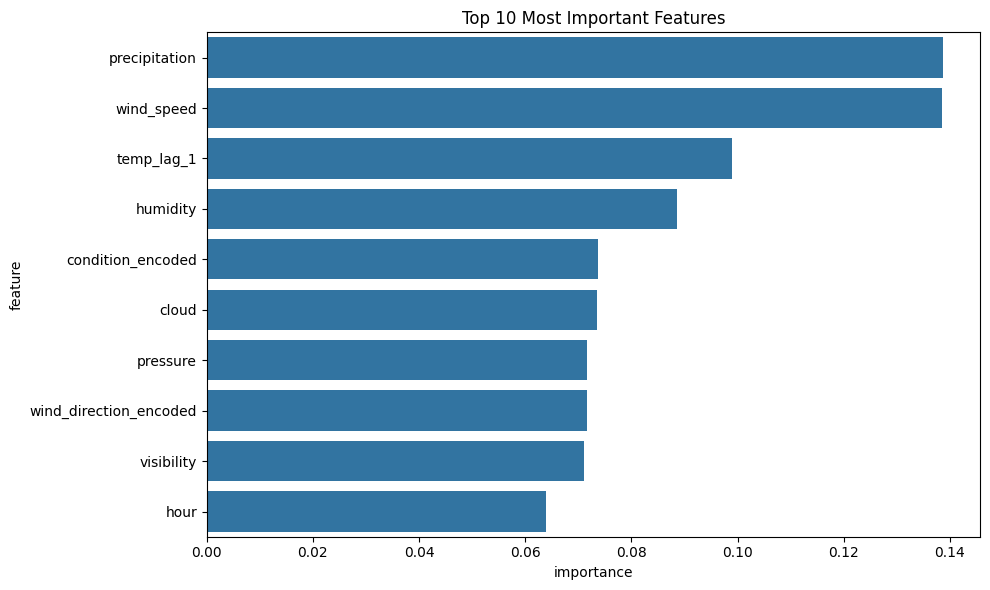

Plotting actual vs predicted temperatures...


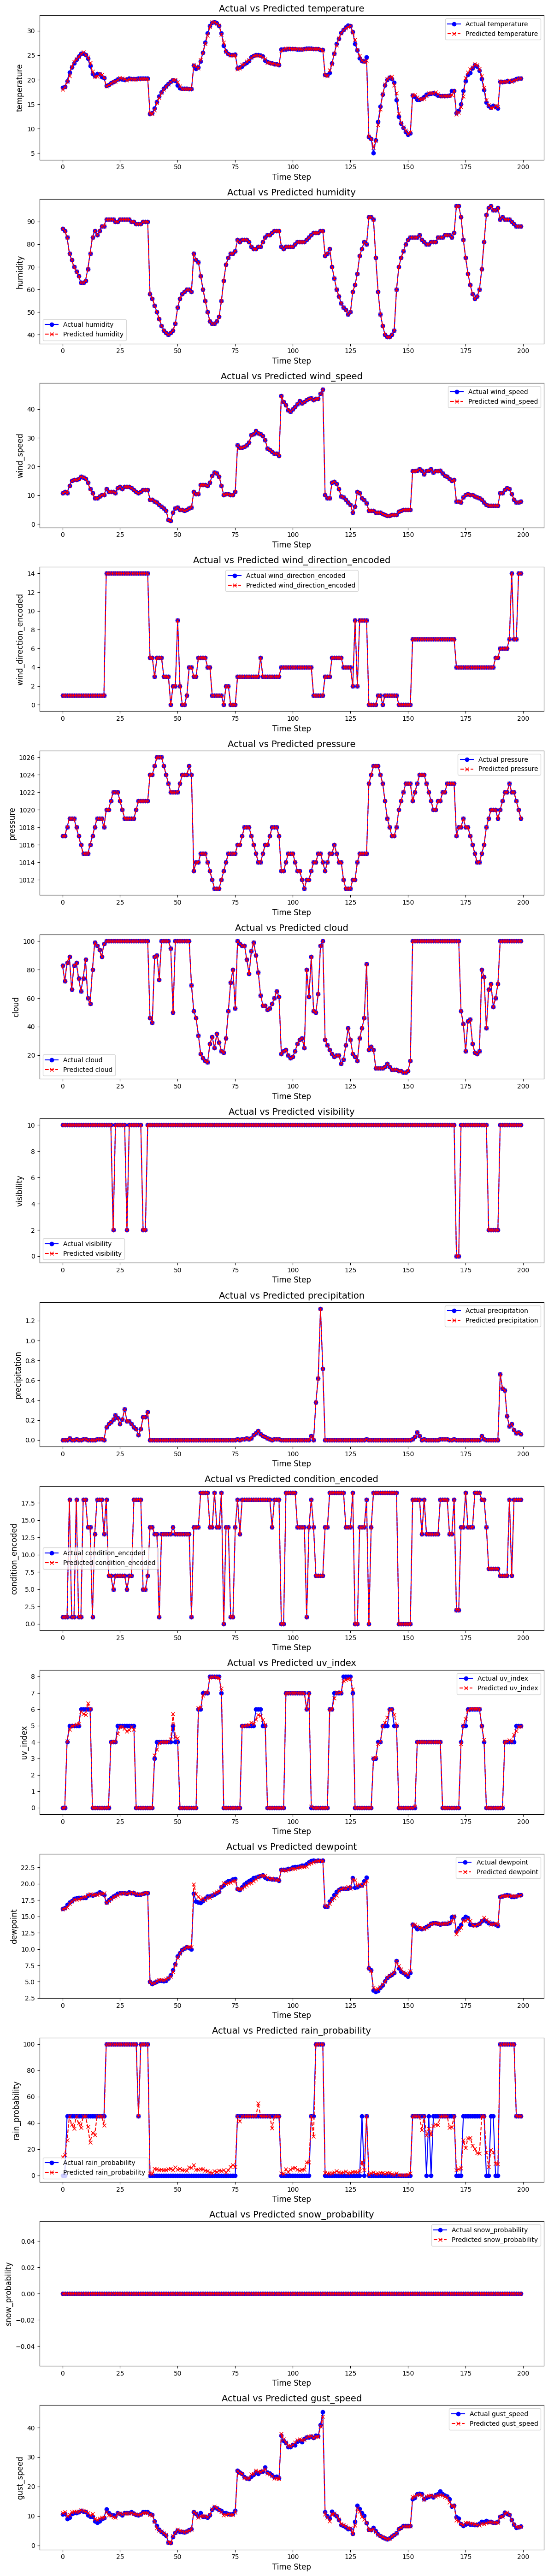

Saving model and associated objects...
Model training and evaluation complete!


In [3]:
#
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor


# 1. Load and Prepare Data
def load_data(filepath):

    df = pd.read_csv(filepath)
    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df

# 2. Feature Engineering
def engineer_features(df):
    # Extract temporal features
    df['hour'] = df['timestamp'].dt.hour
    df['day'] = df['timestamp'].dt.day
    df['month'] = df['timestamp'].dt.month
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    
    # Create lag features for temperature and humidity
    df['temp_lag_1'] = df.groupby('airport_code')['temperature'].shift(1)
    df['temp_lag_3'] = df.groupby('airport_code')['temperature'].shift(3)
    df['humidity_lag_1'] = df.groupby('airport_code')['humidity'].shift(1)
    df['humidity_lag_3'] = df.groupby('airport_code')['humidity'].shift(3)
    df['wind_speed_lag_1'] = df.groupby('airport_code')['wind_speed'].shift(1)
    df['wind_speed_lag_3'] = df.groupby('airport_code')['wind_speed'].shift(3)

    # df['wind_direction_lag_1'] = df.groupby('airport_code')['wind_direction_encoded'].shift(1)
    # df['wind_direction_lag_3'] = df.groupby('airport_code')['wind_direction_encoded'].shift(3)

    df['pressure_lag_1'] = df.groupby('airport_code')['pressure'].shift(1)
    df['pressure_lag_3'] = df.groupby('airport_code')['pressure'].shift(3)
    df['cloud_lag_1'] = df.groupby('airport_code')['cloud'].shift(1)
    df['cloud_lag_3'] = df.groupby('airport_code')['cloud'].shift(3)
    df['visibility_lag_1'] = df.groupby('airport_code')['visibility'].shift(1)
    df['visibility_lag_3'] = df.groupby('airport_code')['visibility'].shift(3)
    df['precipitation_lag_1'] = df.groupby('airport_code')['precipitation'].shift(1)
    df['precipitation_lag_3'] = df.groupby('airport_code')['precipitation'].shift(3)




    
    # Create rolling mean features for temperature, humidity, wind speed, wind direction, and pressure
    df['temp_rolling_mean_6h'] = df.groupby('airport_code')['temperature'].rolling(window=6).mean().reset_index(0, drop=True)
    df['humidity_rolling_mean_6h'] = df.groupby('airport_code')['humidity'].rolling(window=6).mean().reset_index(0, drop=True)
    df['wind_speed_rolling_mean_6h'] = df.groupby('airport_code')['wind_speed'].rolling(window=6).mean().reset_index(0, drop=True)
    
    # df['wind_direction_rolling_mean_6h'] = df.groupby('airport_code')['wind_direction_encoded'].rolling(window=6).mean().reset_index(0, drop=True)
    
    df['pressure_rolling_mean_6h'] = df.groupby('airport_code')['pressure'].rolling(window=6).mean().reset_index(0, drop=True)
    df['cloud_rolling_mean_6h'] = df.groupby('airport_code')['cloud'].rolling(window=6).mean().reset_index(0, drop=True)
    


    # Encode categorical variables
    le = LabelEncoder()
    df['airport_code_encoded'] = le.fit_transform(df['airport_code'])
    df['wind_direction_encoded'] = le.fit_transform(df['wind_direction_symbol'])
    df['condition_encoded'] = le.fit_transform(df['condition'])
    
    return df, le

# 3. Prepare features and target
def prepare_model_data(df):
    features = ['hour', 'day', 'month', 'day_of_week',
                'airport_code_encoded', 'latitude', 'longitude',
                'temp_lag_1', 'temp_lag_3', 'humidity_lag_1',
                'temp_rolling_mean_6h', 'humidity_rolling_mean_6h',
                'wind_speed', 'wind_direction_encoded', 'pressure',
                'humidity', 'cloud', 'visibility', 'precipitation', 
                'condition_encoded', 'wind_speed_lag_1', 'wind_speed_lag_3', 
                'pressure_lag_1', 'pressure_lag_3', 'cloud_lag_1', 'cloud_lag_3',
                'visibility_lag_1', 'visibility_lag_3', 'precipitation_lag_1', 'precipitation_lag_3',
                ]
    
    targets = ['temperature', 'humidity', 'wind_speed', 'wind_direction_encoded', 'pressure', 'cloud', 
               'visibility', 'precipitation', 'condition_encoded', 'uv_index', 'dewpoint', 'rain_probability', 'snow_probability', 'gust_speed']
    
    # Remove rows with NaN values (caused by lag features)
    df_clean = df.dropna(subset=features + targets)
    
    X = df_clean[features]
    y = df_clean[targets]
    
    return X, y, features

from tqdm import tqdm

# 4. Model Training and Evaluation
def train_evaluate_model(X, y):
    # Split data with time series consideration
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Initialize and train model
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    
    multi_target_model = MultiOutputRegressor(rf_model)
    
    # Lists to store metrics
    train_scores = []
    test_scores = []
    
    # Perform cross-validation
    for train_idx, test_idx in tqdm(tscv.split(X), total=tscv.get_n_splits(), desc="Training", unit="fold"):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train model
        multi_target_model.fit(X_train_scaled, y_train)
        
        # Calculate scores
        train_pred = multi_target_model.predict(X_train_scaled)
        test_pred = multi_target_model.predict(X_test_scaled)
        
        train_scores.append(r2_score(y_train, train_pred))
        test_scores.append(r2_score(y_test, test_pred))
    
    print(f"Average Train R2 Score: {np.mean(train_scores):.4f}")
    print(f"Average Test R2 Score: {np.mean(test_scores):.4f}")
    
    return multi_target_model, scaler

# 5. Feature Importance Analysis
def analyze_feature_importance(model, feature_names):
    # Extract feature importances from each estimator and average them
    importances = np.mean([est.feature_importances_ for est in model.estimators_], axis=0)
    
    importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importance.head(10))
    plt.title('Top 10 Most Important Features')
    plt.tight_layout()
    plt.show()
    
    return importance

# 6. Save Model and Scaler
def save_model(model, scaler, le, features, base_path):
    # Create models directory if it doesn't exist
    models_dir = f"../models"
    import os
    os.makedirs(models_dir, exist_ok=True)
    
    # Save model and associated objects
    joblib.dump(model, f"{models_dir}/weather_rf_model.joblib")
    joblib.dump(scaler, f"{models_dir}/weather_scaler.joblib")
    joblib.dump(le, f"{models_dir}/weather_label_encoder.joblib")
    
    # Save feature list
    with open(f"{models_dir}/features.txt", 'w') as f:
        f.write('\n'.join(features))

# 7. Plot Actual vs Predicted Temperatures
def plot_actual_vs_predicted(model, scaler, X, y, n_samples=200):
    import matplotlib.pyplot as plt

    # Scale features
    X_scaled = scaler.transform(X)

    # Predict
    y_pred = model.predict(X_scaled)

    # Select a subset for visualization
    y_subset = y[:n_samples]
    y_pred_subset = y_pred[:n_samples]

    num_targets = len(y.columns)
    plt.figure(figsize=(12, 4 * num_targets))  # Adjust the figure size dynamically based on the number of targets

    for i, target_name in enumerate(y.columns):
        plt.subplot(num_targets, 1, i + 1)
        plt.plot(
            y_subset.iloc[:, i].values,
            label=f"Actual {target_name}",
            color="blue",
            marker="o",
        )
        plt.plot(
            y_pred_subset[:, i],
            label=f"Predicted {target_name}",
            color="red",
            linestyle="--",
            marker="x",
        )
        plt.title(f"Actual vs Predicted {target_name}", fontsize=14)
        plt.xlabel("Time Step", fontsize=12)
        plt.ylabel(target_name, fontsize=12)
        plt.legend()

    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    import os

    # Get the current working directory
    BASE_DIR = os.getcwd()
    DATA_PATH = os.path.join(BASE_DIR, "../data/historical_weather_data.csv")
    BASE_PATH = "weather-alert-system"

    # 1. Load data
    print("Loading data...")
    df = load_data(DATA_PATH)
    
    # 2. Engineer features
    print("Engineering features...")
    df_engineered, label_encoder = engineer_features(df)
    
    # 3. Prepare model data
    print("Preparing model data...")
    X, y, features = prepare_model_data(df_engineered)
    
    # 4. Train and evaluate model
    print("Training and evaluating model...")
    model, scaler = train_evaluate_model(X, y)
    
    # 5. Analyze feature importance
    print("Analyzing feature importance...")
    feature_importance = analyze_feature_importance(model, features)
    
    # 6. Plot actual vs predicted temperatures
    print("Plotting actual vs predicted temperatures...")
    plot_actual_vs_predicted(model, scaler, X, y)
    
    # 7. Save model and associated objects
    print("Saving model and associated objects...")
    save_model(model, scaler, label_encoder, features, BASE_PATH)
    
    print("Model training and evaluation complete!")


# TRAIN MODEL 01 - 01 - 2025

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import joblib
import os

class AviationWeatherPredictor:
    def __init__(self, model_dir='backend/ml/models/saved_models'):
        self.model_dir = model_dir
        self.models = {}
        self.label_encoders = {}
        self.scalers = {}
        self.features = None
        self.hours_ahead = [1, 2, 3, 6, 12, 24]
        
        # Parameters important for aviation
        self.weather_params = [
            'temperature',         # Nhiệt độ
            'humidity',           # Độ ẩm
            'wind_speed',         # Tốc độ gió
            'wind_direction',     # Hướng gió
            'gust_speed',         # Tốc độ gió giật
            'pressure',           # Áp suất
            'precipitation',      # Lượng mưa
            'rain_probability',   # Xác suất mưa
            'snow_probability',   # Xác suất tuyết
            'uv_index',          # Chỉ số UV
            'dewpoint',          # Điểm sương
            'visibility',         # Tầm nhìn
            'cloud',             # Độ che phủ của mây
            'condition_encoded'   # Tình trạng thời tiết
        ]
        
        os.makedirs(model_dir, exist_ok=True)

    def load_data(self, file_path):
        df = pd.read_csv(file_path)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        return df

    def preprocess_data(self, df):
        # Convert categorical variables
        self.label_encoders['condition'] = LabelEncoder()
        self.label_encoders['wind_direction_symbol'] = LabelEncoder()
        
        df['condition_encoded'] = self.label_encoders['condition'].fit_transform(df['condition'])
        df['wind_direction_symbol_encoded'] = self.label_encoders['wind_direction_symbol'].fit_transform(df['wind_direction_symbol'])
        
        # Create time-based features
        df['hour'] = df['timestamp'].dt.hour
        df['day'] = df['timestamp'].dt.day
        df['month'] = df['timestamp'].dt.month
        df['day_of_week'] = df['timestamp'].dt.dayofweek
        
        # Calculate additional features that might be useful
        df['temp_humidity_ratio'] = df['temperature'] / df['humidity']
        df['wind_pressure_ratio'] = df['wind_speed'] / df['pressure']
        
        # Select features for training
        self.features = [
            'temperature', 'humidity', 'wind_speed', 'wind_direction',
            'gust_speed', 'pressure', 'precipitation', 'rain_probability',
            'snow_probability', 'uv_index', 'cloud', 'condition_encoded',
            'wind_direction_symbol_encoded', 'dewpoint', 'visibility',
            'temp_humidity_ratio', 'wind_pressure_ratio',
            'hour', 'day', 'month', 'day_of_week'
        ]
        
        return df

    def create_hourly_targets(self, df):
        """Create targets for each hour ahead for all aviation weather parameters"""
        targets = {}
        
        for hours in self.hours_ahead:
            targets[f'{hours}h'] = {}
            for param in self.weather_params:
                targets[f'{hours}h'][param] = df.groupby('airport_code')[param].shift(-hours)
        
        return targets

    def train_models(self, df, targets):
        scores = {}
        
        for hours, target_dict in targets.items():
            print(f"\nTraining models for {hours} prediction...")
            self.models[hours] = {}
            scores[hours] = {}
            self.scalers[hours] = {}
            
            for param in self.weather_params:
                print(f"Training {param} model...")
                target = target_dict[param]
                
                # Remove NaN values
                mask = ~target.isna()
                X = df[self.features][mask]
                y = target[mask]
                
                # Split data
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.2, random_state=42
                )
                
                # Scale features
                self.scalers[hours][param] = StandardScaler()
                X_train_scaled = self.scalers[hours][param].fit_transform(X_train)
                X_test_scaled = self.scalers[hours][param].transform(X_test)
                
                # Train model with optimized parameters for each weather parameter
                self.models[hours][param] = self._get_optimized_model(param)
                self.models[hours][param].fit(X_train_scaled, y_train)
                
                # Evaluate model
                y_pred = self.models[hours][param].predict(X_test_scaled)
                scores[hours][param] = {
                    'mae': mean_absolute_error(y_test, y_pred),
                    'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
                    'r2': r2_score(y_test, y_pred)
                }
                
                # Save model and scaler
                self.save_model(hours, param)
                
        return scores

    def _get_optimized_model(self, param):
        """Return optimized RandomForest model based on parameter type"""
        base_params = {
            'n_estimators': 200,
            'random_state': 42,
            'n_jobs': -1
        }
        
        # Optimize parameters based on weather parameter type
        if param in ['visibility', 'cloud']:
            # These need higher precision
            return RandomForestRegressor(
                **base_params,
                max_depth=25,
                min_samples_split=5,
                min_samples_leaf=2
            )
        elif param in ['wind_speed', 'wind_direction', 'gust_speed']:
            # These can be more volatile
            return RandomForestRegressor(
                **base_params,
                max_depth=20,
                min_samples_split=10,
                min_samples_leaf=4
            )
        else:
            # Default parameters for other variables
            return RandomForestRegressor(
                **base_params,
                max_depth=15,
                min_samples_split=8,
                min_samples_leaf=3
            )

    def predict_next_hours(self, current_data, airport_code, num_hours=12):
        """Predict all aviation weather parameters for the next specified hours"""
        predictions = []
        current_hour = pd.to_datetime(current_data['timestamp'].iloc[0])
        
        base_data = current_data[current_data['airport_code'] == airport_code].iloc[0].to_dict()
        
        for hour in range(1, num_hours + 1):
            next_hour = current_hour + timedelta(hours=hour)
            prediction = base_data.copy()
            prediction['timestamp'] = next_hour
            
            # Find closest model
            model_hour = min(self.hours_ahead, key=lambda x: abs(x - hour))
            model_key = f'{model_hour}h'
            
            # Update all weather parameters
            for param in self.weather_params:
                X = pd.DataFrame([prediction])[self.features]
                X_scaled = self.scalers[model_key][param].transform(X)
                predicted_value = self.models[model_key][param].predict(X_scaled)[0]
                prediction[param] = predicted_value
            
            predictions.append(prediction)
        
        return pd.DataFrame(predictions)

    def plot_aviation_predictions(self, current_data, airport_code, num_hours=12):
        """Plot comprehensive aviation weather predictions"""
        predictions = self.predict_next_hours(current_data, airport_code, num_hours)
        
        # Create subplots for each important aviation parameter
        fig, axs = plt.subplots(4, 2, figsize=(15, 20))
        fig.suptitle(f'Aviation Weather Predictions for {airport_code}')
        
        # Plot parameters important for aviation
        params_to_plot = [
            ('visibility', 'Visibility (km)', 0, 0),
            ('cloud', 'Cloud Cover (%)', 0, 1),
            ('wind_speed', 'Wind Speed (km/h)', 1, 0),
            ('gust_speed', 'Gust Speed (km/h)', 1, 1),
            ('precipitation', 'Precipitation (mm)', 2, 0),
            ('pressure', 'Pressure (mb)', 2, 1),
            ('temperature', 'Temperature (°C)', 3, 0),
            ('humidity', 'Humidity (%)', 3, 1)
        ]
        
        for param, title, row, col in params_to_plot:
            axs[row, col].plot(predictions['timestamp'], predictions[param])
            axs[row, col].set_title(title)
            axs[row, col].set_xticklabels(
                predictions['timestamp'].dt.strftime('%H:%M'),
                rotation=45
            )
            axs[row, col].grid(True)
        
        plt.tight_layout()
        plt.show()

    def save_model(self, hours, param):
        model_path = os.path.join(self.model_dir, f'rf_model_{param}_{hours}.joblib')
        joblib.dump(self.models[hours][param], model_path)
        
        scaler_path = os.path.join(self.model_dir, f'scaler_{param}_{hours}.joblib')
        joblib.dump(self.scalers[hours][param], scaler_path)
        
        for name, encoder in self.label_encoders.items():
            encoder_path = os.path.join(self.model_dir, f'encoder_{name}.joblib')
            joblib.dump(encoder, encoder_path)

    def load_models(self):
        try:
            for hours in self.hours_ahead:
                hours_key = f'{hours}h'
                self.models[hours_key] = {}
                self.scalers[hours_key] = {}
                
                for param in self.weather_params:
                    model_path = os.path.join(self.model_dir, f'rf_model_{param}_{hours_key}.joblib')
                    self.models[hours_key][param] = joblib.load(model_path)
                    
                    scaler_path = os.path.join(self.model_dir, f'scaler_{param}_{hours_key}.joblib')
                    self.scalers[hours_key][param] = joblib.load(scaler_path)
            
            for name in ['condition', 'wind_direction_symbol']:
                encoder_path = os.path.join(self.model_dir, f'encoder_{name}.joblib')
                self.label_encoders[name] = joblib.load(encoder_path)
                
            return True
        except Exception as e:
            print(f"Error loading models: {str(e)}")
            return False

# Example usage
def main():
    predictor = AviationWeatherPredictor()
    
    if not predictor.load_models():
        print("Training new models...")
        df = predictor.load_data('backend/ml/data/historical_weather_data.csv')
        df = predictor.preprocess_data(df)
        targets = predictor.create_hourly_targets(df)
        scores = predictor.train_models(df, targets)
        
        # Print scores for all parameters
        for hours, params in scores.items():
            print(f"\nScores for {hours} predictions:")
            for param, metrics in params.items():
                print(f"\n{param.capitalize()}:")
                print(f"MAE: {metrics['mae']:.2f}")
                print(f"RMSE: {metrics['rmse']:.2f}")
                print(f"R2: {metrics['r2']:.2f}")
    
    return predictor

if __name__ == "__main__":
    predictor = main()